In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from skopt import BayesSearchCV
from sklearn.inspection import permutation_importance

from prepare_data import input_data

### Building ML models to classify EEG signals into seizure and free seizure segments.


In [ ]:
ml_models = []
scores = []
X_train, X_test, y_train, y_test = input_data(val=False)

In [ ]:
def train_eval(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    performance = [model.score(X_test, y_test)]
    performance.extend(list(report['1'].values())[0:3])
    return performance

In [ ]:
def plot_feature_importances(model):
    result = permutation_importance(model, X_test, y_test, n_repeats=10,
                                    random_state=10, n_jobs=2)
    sorted_idx = result.importances_mean.argsort()
    sorted_idx = sorted_idx[-20:]
    fig = plt.figure(figsize=(5, 5))
    plt.subplot(1, 1, 1)
    plt.boxplot(result.importances[sorted_idx].T, vert=False,
                labels=[str(i) for i in sorted_idx])
    plt.title(model.__class__.__name__ + " Permutation Importance")
    plt.xlabel("Decrease in accuracy")
    fig.tight_layout()
    plt.show()

### **Logistic Regression**

*   Hyperparameter Tuning



In [ ]:
lr = LogisticRegression(random_state=10)
param_bayes  = {'solver': ['newton-cg', 'sag', 'liblinear'],
                'penalty': ['l2'],
                'C': np.linspace(0.01, 1, 100),
                'max_iter': [5000, 10000, 20000]}
cl_opt = BayesSearchCV(estimator=lr,
                       search_spaces=param_bayes,
                       scoring="accuracy",
                       n_jobs=-1,
                       random_state=0,
                       verbose=0)

cl_opt.fit(X_train, y_train)
print(str(cl_opt.best_params_))

In [ ]:
lr = LogisticRegression(max_iter=5000, solver='sag', C=0.14, random_state=10)
performance = train_eval(lr)
ml_models.append(lr.__class__.__name__)
scores.append(performance)
print(performance)

[0.621195652173913, 0.6455882352941177, 0.49050279329608937, 0.5574603174603174]


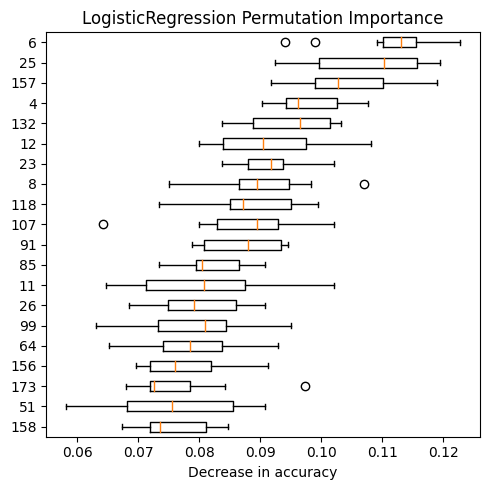

In [ ]:
plot_feature_importances(lr)

### K-Nearest Neighbors

*   Hyperparameter Tuning

In [ ]:
knn = KNeighborsClassifier()
param_bayes  = {'n_neighbors': np.arange(2,6),
                'weights': ['uniform', 'distance'],
                'algorithm': ['auto','ball_tree','kd_tree','brute']}
cl_opt = BayesSearchCV(estimator=knn,
                       search_spaces=param_bayes,
                       scoring="accuracy",
                       n_jobs=-1,
                       random_state=0,
                       verbose=0)
cl_opt.fit(X_train, y_train)
print(str(cl_opt.best_params_))

In [ ]:
knn = KNeighborsClassifier(n_neighbors=2, algorithm='auto', weights='distance')
performance = train_eval(knn)
ml_models.append(knn.__class__.__name__)
scores.append(performance)
print(performance)

[0.9983695652173913, 1.0, 0.9966480446927374, 0.9983212087297145]


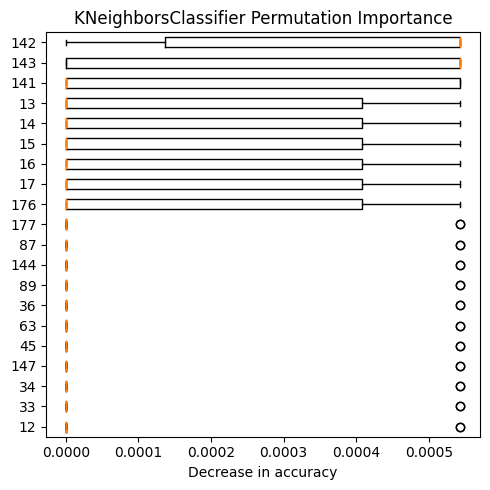

In [ ]:
plot_feature_importances(knn)

### Multi-Layer Perceptron
*   Hyperparameter Tuning



In [ ]:
mlp = MLPClassifier(random_state=10)
param_bayes  = {'hidden_layer_sizes':[10, 100, 200, 500],
                'alpha': 10.0 ** -np.arange(1, 10),
                'max_iter': [1000, 5000, 10000]}
cl_opt = BayesSearchCV(estimator=mlp,
                       search_spaces=param_bayes,
                       scoring="accuracy",
                       n_jobs=-1,
                       random_state=0,
                       verbose=0)
cl_opt.fit(X_train, y_train)
print(str(cl_opt.best_params_))

In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=500, alpha=1e-09, max_iter=5000,
                    early_stopping=True, random_state=10)
performance = train_eval(mlp)
ml_models.append(mlp.__class__.__name__)
scores.append(performance)
print(performance)

[0.9929347826086956, 0.9932885906040269, 0.9921787709497206, 0.9927333705980994]


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


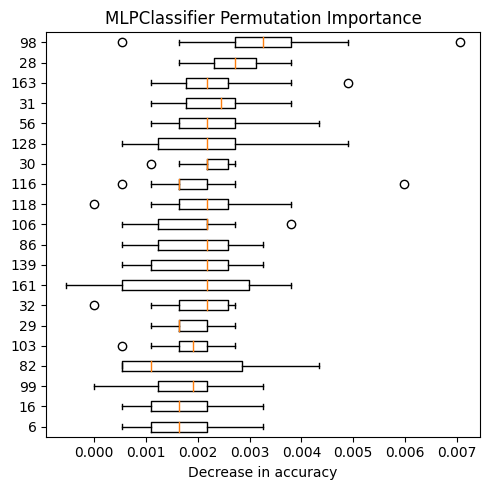

In [ ]:
plot_feature_importances(mlp)

### SVM
*   Hyperparameter Tuning



In [ ]:
svm = SVC(random_state=10)
param_bayes  = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'kernel': ['rbf']}
cl_opt = BayesSearchCV(estimator=svm,
                       search_spaces=param_bayes,
                       scoring="accuracy",
                       n_jobs=-1,
                       random_state=0,
                       verbose=0)
cl_opt.fit(X_train, y_train)
print(str(cl_opt.best_params_))

In [ ]:
final_model = cl_opt.best_estimator_
final_model

SVC(C=1000, gamma=0.01, random_state=10)

In [ ]:
svm = SVC(C=1000, gamma=0.01, kernel='rbf', random_state=10)
performance = train_eval(svm)
ml_models.append(svm.__class__.__name__)
scores.append(performance)
print(performance)

[0.9934782608695653, 0.9889258028792912, 0.9977653631284916, 0.9933259176863181]


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


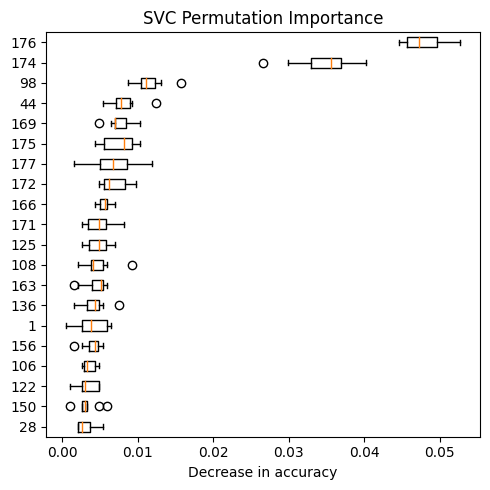

In [ ]:
plot_feature_importances(svm)

### Decision Trees
*   Hyperparameter Tuning



In [ ]:
dt = DecisionTreeClassifier(random_state=10)

param_bayes = {'criterion' :['gini', 'entropy'],
               'max_depth' : [5, 10, 20, 50, 100],
               'ccp_alpha': [0.1, .01, .001, 0],
               }
dt_opt = BayesSearchCV(estimator=dt,
                       search_spaces=param_bayes,
                       scoring="accuracy",
                       n_jobs=-1,
                       random_state=0,
                       verbose=0)
dt_opt.fit(X_train, y_train)

print(str(dt_opt.best_params_))

In [ ]:
print(dt_opt.best_estimator_)

DecisionTreeClassifier(ccp_alpha=0, criterion='entropy', max_depth=50,
                       random_state=10)


In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=50, ccp_alpha=0,
                            random_state=10)
performance = train_eval(dt)
ml_models.append(dt.__class__.__name__)
scores.append(performance)
print(performance)

[0.9771739130434782, 0.9640914036996736, 0.9899441340782122, 0.9768467475192943]


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


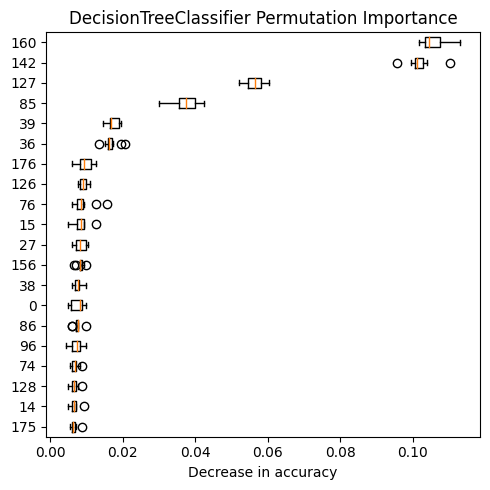

In [ ]:
plot_feature_importances(dt)

### Gradient Boosting
*   Hyperparameter Tuning



In [ ]:
gb = GradientBoostingClassifier(random_state=10)

param_grid = {"n_estimators": [100, 150, 200, 300],
              "learning_rate": np.arange(0.1, 1, 0.1),
              "subsample": [0.5, 0.7, 1.0],
              "max_depth": np.arange(3, 11, 1),
             }
gb_opt = BayesSearchCV(estimator = gb,
                      search_spaces = param_grid,
                      scoring = "accuracy",
                      n_jobs = -1,
                      verbose=0)

gb_opt.fit(X_train, y_train)
print(str(gb_opt.best_params_))

In [ ]:
print(gb_opt.best_estimator_)

In [ ]:
gb = GradientBoostingClassifier(n_estimators=300, learning_rate=0.3, max_depth=7,
                                subsample=1.0, random_state=10)
performance = train_eval(gb)
ml_models.append(gb.__class__.__name__)
scores.append(performance)
print(performance)

[0.9956521739130435, 0.9922308546059934, 0.9988826815642458, 0.9955456570155901]


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


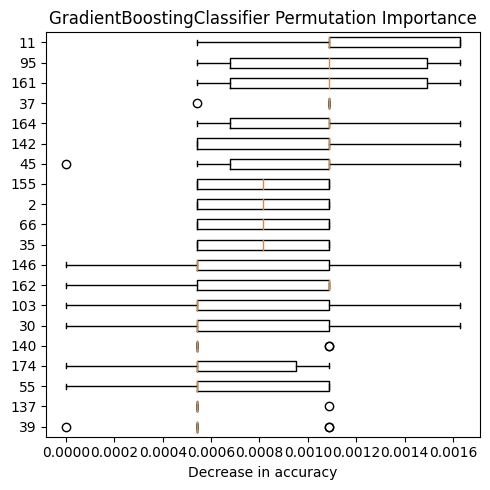

In [ ]:
plot_feature_importances(gb)

### Summary of the results of ML models

In [ ]:
df_eval = pd.DataFrame(scores,
                      index = ml_models,
                      columns=['Accuracy', 'Precision', 'Recall', 'F1'])
df_eval = df_eval.sort_values('Accuracy', ascending=False)
print(df_eval)

                            Accuracy  Precision    Recall        F1
KNeighborsClassifier        0.998370   1.000000  0.996648  0.998321
GradientBoostingClassifier  0.995652   0.992231  0.998883  0.995546
SVC                         0.993478   0.988926  0.997765  0.993326
MLPClassifier               0.992935   0.993289  0.992179  0.992733
DecisionTreeClassifier      0.977174   0.964091  0.989944  0.976847
LogisticRegression          0.621196   0.645588  0.490503  0.557460
